In [49]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

# Подготовка данных

In [2]:
calls = pd.read_csv('calls.csv')
internet = pd.read_csv('internet.csv')
messages = pd.read_csv('messages.csv')
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')

## calls.csv

In [3]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


В датасете calls не было обнаружено ошибок или пустых значений. Посчитаем количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя.




In [5]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

In [6]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month

In [7]:
calls_by_month = calls.groupby(['user_id', 'month']).agg(
    {
        'id': 'count',
        'duration': lambda x :np.ceil(x).sum()
    }
).rename(columns={'id': 'count_of_calls'})
calls_by_month

count_of_calls  duration
user_id month                          
1000    5                  22     159.0
        6                  43     172.0
        7                  47     340.0
        8                  52     408.0
        9                  58     466.0
...                       ...       ...
1498    10                 41     247.0
1499    9                   9      70.0
        10                 68     449.0
        11                 74     612.0
        12                 69     492.0

[3174 rows x 2 columns]

## messages.csv

In [8]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [9]:
messages.describe()

,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


В датасете messages не было обнаружено ошибок или пустых значений. Посчитаем количество отправленных сообщений по месяцам для каждого пользователя.


In [10]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

In [11]:
messages['month'] = messages['message_date'].dt.month

Рассчитано количество отправленных сообщений по месяцам для каждого пользователя.

In [12]:
messages_by_month = messages.groupby(['user_id', 'month']).agg({'id': 'count'}).rename(columns={'id': 'count_of_messages'})
messages_by_month

count_of_messages
user_id month                   
1000    5                     22
        6                     60
        7                     75
        8                     81
        9                     57
...                          ...
1498    10                    42
1499    9                     11
        10                    48
        11                    59
        12                    66

[2717 rows x 1 columns]

## internet.csv

In [13]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [14]:
internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


In [15]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

In [16]:
internet['month'] = internet['session_date'].dt.month

In [17]:
internet_by_month = internet.groupby(['user_id', 'month']).agg(
    {'mb_used': lambda x: np.ceil((x.sum())/1024)}
).rename(columns={'mb_used': 'gb_used'})
internet_by_month

gb_used
user_id month         
1000    5          3.0
        6         23.0
        7         14.0
        8         14.0
        9         15.0
...                ...
1498    10        21.0
1499    9          2.0
        10        18.0
        11        18.0
        12        13.0

[3203 rows x 1 columns]

## Помесячная выручка с каждого пользователя

In [25]:
stats_per_user = calls_by_month.join(messages_by_month, on=['user_id', 'month'], how='outer')
stats_per_user = stats_per_user.join(internet_by_month, on=['user_id', 'month'], how='outer')
#users.set_index('user_id', inplace=True)
stats_per_user = stats_per_user.join(users['tariff'], on='user_id', how='left')
stats_per_user = stats_per_user.fillna(0)
stats_per_user

count_of_calls  duration  count_of_messages  gb_used tariff
user_id month                                                             
1000    5                22.0     159.0               22.0      3.0  ultra
        6                43.0     172.0               60.0     23.0  ultra
        7                47.0     340.0               75.0     14.0  ultra
        8                52.0     408.0               81.0     14.0  ultra
        9                58.0     466.0               57.0     15.0  ultra
...                       ...       ...                ...      ...    ...
1498    10               41.0     247.0               42.0     21.0  smart
1499    9                 9.0      70.0               11.0      2.0  smart
        10               68.0     449.0               48.0     18.0  smart
        11               74.0     612.0               59.0     18.0  smart
        12               69.0     492.0               66.0     13.0  smart

[3214 rows x 5 columns]

In [26]:
def calculate_total_cost(minutes_used, messages_used, internet_used_mb, tariff):
    """
    Вычисляет итоговую стоимость для пользователя на основе его тарифа и использования услуг.

    Параметры:
    - minutes_used: количество использованных минут.
    - messages_used: количество отправленных сообщений.
    - internet_used_mb: количество использованного интернет-трафика (в мегабайтах).
    - tariff: тип тарифа ('ultra' или 'smart').

    Возвращает:
    - total_cost: итоговая стоимость.
    """

    # Определяем параметры тарифов
    if tariff == 'ultra':
        monthly_fee = 1950  # Абонентская плата
        minutes_included = 3000  # Включено минут
        messages_included = 1000  # Включено сообщений
        internet_included_gb = 30  # Включено интернет-трафика (в мегабайтах)
        cost_per_minute = 1  # Стоимость дополнительной минуты
        cost_per_message = 1  # Стоимость дополнительного сообщения
        cost_per_gb = 150  # Стоимость дополнительного гигабайта
    elif tariff == 'smart':
        monthly_fee = 550  # Абонентская плата
        minutes_included = 500  # Включено минут
        messages_included = 50  # Включено сообщений
        internet_included_gb = 15  # Включено интернет-трафика (в мегабайтах)
        cost_per_minute = 3  # Стоимость дополнительной минуты
        cost_per_message = 3  # Стоимость дополнительного сообщения
        cost_per_gb = 200  # Стоимость дополнительного гигабайта
    else:
        raise ValueError("Неизвестный тариф. Используйте 'ultra' или 'smart'.")

    # Вычисляем дополнительные минуты, сообщения и интернет-трафик
    extra_minutes = max(minutes_used - minutes_included, 0)
    extra_messages = max(messages_used - messages_included, 0)
    extra_internet_gb = max(internet_used_mb - internet_included_gb, 0)


    # Вычисляем итоговую стоимость
    total_cost = (
            monthly_fee
            + extra_minutes * cost_per_minute
            + extra_messages * cost_per_message
            + extra_internet_gb * cost_per_gb
    )

    return total_cost

In [27]:
stats_per_user['total_cost'] = stats_per_user.apply(lambda row: calculate_total_cost(
    minutes_used=row['duration'],
    messages_used=row['count_of_messages'],
    internet_used_mb=row['gb_used'],
    tariff=row['tariff']),
    axis=1)


In [28]:
stats_per_user.reset_index(inplace=True)

In [29]:
stats_per_user.loc[:,['user_id','month', 'tariff', 'total_cost']]


,user_id,month,tariff,total_cost
0,1000,5,ultra,1950.0
1,1000,6,ultra,1950.0
2,1000,7,ultra,1950.0
3,1000,8,ultra,1950.0
4,1000,9,ultra,1950.0
...,...,...,...,...
3209,1498,10,smart,1750.0
3210,1499,9,smart,550.0
3211,1499,10,smart,1150.0
3212,1499,11,smart,1513.0


# Анализ данных

## Анализ звонков по тарифам

### ultra

<Axes: >

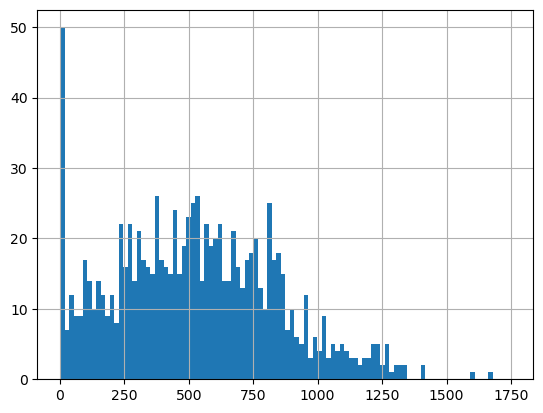

In [30]:
stats_per_user.loc[stats_per_user['tariff'] == 'ultra', 'duration'].hist(range=(0, 1750), bins=100)

In [31]:
stats_per_user.loc[stats_per_user['tariff'] == 'ultra', 'duration'].describe()

count     985.000000
mean      526.623350
std       317.606098
min         0.000000
25%       284.000000
50%       518.000000
75%       752.000000
max      1673.000000
Name: duration, dtype: float64

In [ ]:
stats_per_user.loc[stats_per_user['tariff'] == 'ultra', 'duration']

У большинства пользователей длительность звонков находится в пределах 284–752 минут.
Есть значительное число пользователей, которые либо не используют звонки вовсе, либо используют их в небольшом объеме.

С точки зрения включенных в пакет минут, можно отметить, что ни один клиент и данной выборки не превысил бесплатный лимит в 3000 минут в месяц.

В итоге, можно заключить, что для тарифа "Ultra" характерны короткие и средние по длительности звонки, а долгие звонки встречаются редко.



### smart

<Axes: >

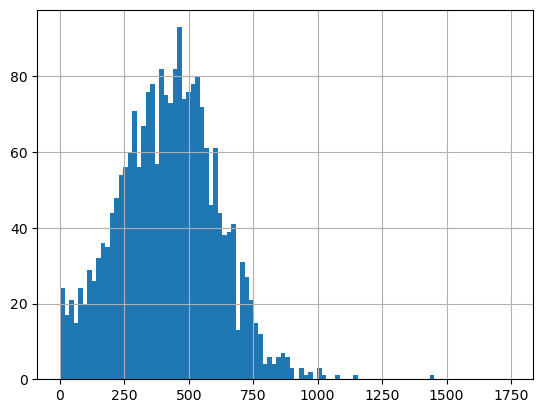

In [32]:
stats_per_user.loc[stats_per_user['tariff'] == 'smart', 'duration'].hist(range=(0, 1750), bins=100)

In [34]:
stats_per_user.loc[stats_per_user['tariff'] == 'smart', 'duration'].describe()

count    2229.000000
mean      417.934948
std       190.313730
min         0.000000
25%       282.000000
50%       422.000000
75%       545.000000
max      1435.000000
Name: duration, dtype: float64

Отклонение длительности звонков от среднего значения составляет примерно 190 единиц времени. Это указывает на меньшее разнообразие длительностей звонков по сравнению с тарифом "Ultra".

Гистограмма показывает, что большинство звонков для тарифа "Smart" имеют меньшую длительность. Частота звонков резко снижается по мере увеличения длительности. Основная масса звонков находится в диапазоне до 500 единиц времени, а звонки длительностью более 1000 единиц времени встречаются крайне редко.

В таком случае, можно отметить, что средняя длительность звонков в 418 единиц времени близка к лимиту в 500 минут, что указывает на более интенсивное использование тарифа "Smart" пользователями по сравнению с тарифом "Ultra". Также видно, что значительная часть звонков находится в диапазоне, который близок к этому лимиту.

## Анализ сообщений

### ultra

In [35]:
stats_per_user.loc[stats_per_user['tariff'] == 'ultra', 'count_of_messages'].describe()

count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: count_of_messages, dtype: float64

<Axes: >

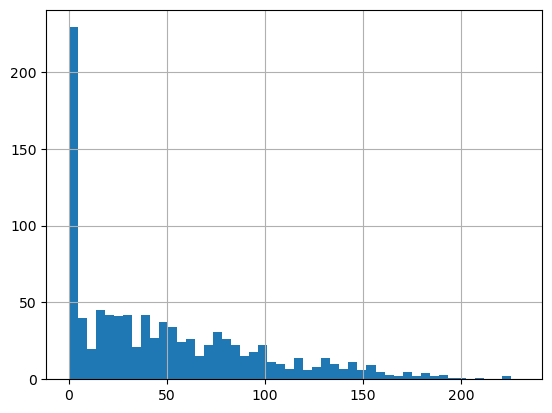

In [37]:
stats_per_user.loc[stats_per_user['tariff'] == 'ultra', 'count_of_messages'].hist(range=(0, 230), bins=50)

Клиенты очень мало пользуются сообщениями. Ни один из клиентов данной выборки не превысил бесплатный лимит в 1000.

### smart

In [38]:
stats_per_user.loc[stats_per_user['tariff'] == 'smart', 'count_of_messages'].describe()


count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: count_of_messages, dtype: float64

<Axes: >

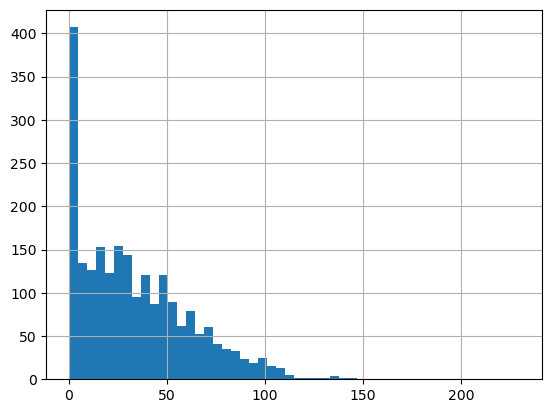

In [39]:
stats_per_user.loc[stats_per_user['tariff'] == 'smart', 'count_of_messages'].hist(range=(0, 230), bins=50)


Около 25% клиентов из выборки тарифа смарт не укладываются в бесплатный лимит 50 сообщений. Выборка скошена влево.

## Анализ интернета


### ultra

In [40]:
stats_per_user.loc[stats_per_user['tariff'] == 'ultra', 'gb_used'].describe()


count    985.000000
mean      19.494416
std        9.853511
min        0.000000
25%       12.000000
50%       19.000000
75%       27.000000
max       49.000000
Name: gb_used, dtype: float64

<Axes: >

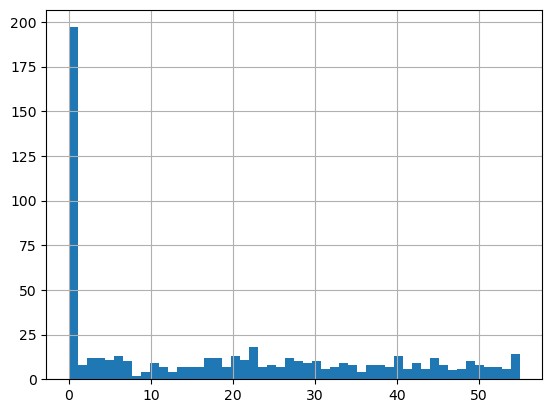

In [41]:
stats_per_user.loc[stats_per_user['tariff'] == 'ultra', 'count_of_messages'].hist(range=(0, 55), bins=50)


### smart

In [44]:
stats_per_user.loc[stats_per_user['tariff'] == 'smart', 'count_of_messages'].describe()

count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: count_of_messages, dtype: float64

<Axes: >

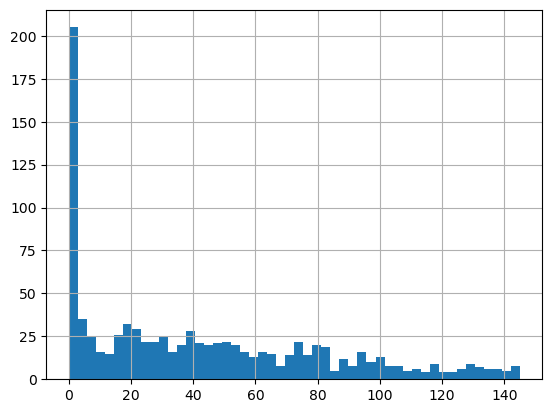

In [45]:
stats_per_user.loc[stats_per_user['tariff'] == 'ultra', 'count_of_messages'].hist(range=(0,145), bins=50)


##

In [47]:
stats_per_user.loc[:,'total_cost'].describe()


count    3214.000000
mean     1529.076229
std       798.251091
min       550.000000
25%       750.000000
50%      1653.500000
75%      1950.000000
max      6770.000000
Name: total_cost, dtype: float64

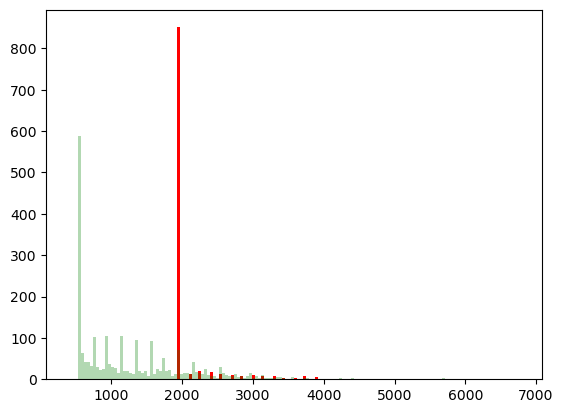

In [61]:
plt.hist(x=(stats_per_user.loc[stats_per_user['tariff'] == 'ultra','total_cost']), bins=150, color='red', range=(400,6770))
plt.hist(x=(stats_per_user.loc[stats_per_user['tariff'] == 'smart','total_cost']), bins=150, color='green', range=(400,6770), alpha=0.3)
plt.show();


In [62]:
stats_per_user.loc[stats_per_user['tariff'] == 'ultra','total_cost'].sum()

2039100.0

In [63]:
stats_per_user.loc[stats_per_user['tariff'] == 'smart','total_cost'].sum()

2875351.0

In [65]:
users.groupby('tariff').agg({'tariff': 'count'})

,tariff
tariff,
smart,351
ultra,149


# Проверка гипотез

### Гипотеза 1: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

- **Нулевая гипотеза (H₀)**: Средняя выручка пользователей тарифов «Ультра» и «Смарт» одинакова.
  $$
  H₀: \mu_{\text{Ультра}} = \mu_{\text{Смарт}}
  $$
- **Альтернативная гипотеза (H₁)**: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.
  $$
  H₁: \mu_{\text{Ультра}} \neq \mu_{\text{Смарт}}
  $$




In [68]:
# Разделение данных на две группы по тарифам
ultra = stats_per_user[stats_per_user['tariff'] == 'ultra']['total_cost']
smart = stats_per_user[stats_per_user['tariff'] == 'smart']['total_cost']

# Проверка нормальности распределения
ultra_normality = st.shapiro(ultra)
smart_normality = st.shapiro(smart)

print(f"Нормальность распределения для Ultra: {ultra_normality}")
print(f"Нормальность распределения для Smart: {smart_normality}")

# Если данные распределены нормально, используем t-тест
if ultra_normality.pvalue > 0.05 and smart_normality.pvalue > 0.05:
    t_stat, p_value = st.ttest_ind(ultra, smart)
    print(f"T-статистика: {t_stat}, P-значение: {p_value}")
else:
    # Если данные не распределены нормально, используем тест Манна-Уитни
    u_stat, p_value = st.mannwhitneyu(ultra, smart)
    print(f"U-статистика: {u_stat}, P-значение: {p_value}")

# Принятие решения на основе p-value
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: средняя выручка различается.")
else:
    print("Не отвергаем нулевую гипотезу: средняя выручка не различается.")

Нормальность распределения для Ultra: ShapiroResult(statistic=0.36734445463678367, pvalue=8.752860960262385e-50)
Нормальность распределения для Smart: ShapiroResult(statistic=0.8417349182282018, pvalue=1.5154174186526447e-42)
U-статистика: 1796019.0, P-значение: 1.9803845594554806e-187
Отвергаем нулевую гипотезу: средняя выручка различается.


### Гипотеза 2: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

- **Нулевая гипотеза (H₀)**: Средняя выручка пользователей из Москвы и других регионов одинакова.
  $$
  H₀: \mu_{\text{Москва}} = \mu_{\text{Другие регионы}}
  $$

- **Альтернативная гипотеза (H₁)**: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
  $$
  H₁: \mu_{\text{Москва}} \neq \mu_{\text{Другие регионы}}
  $$

In [69]:
stats_per_user = stats_per_user.join(users['city'], on='user_id', how='left')

In [70]:
# Разделение данных на две группы по региону
moscow = stats_per_user[stats_per_user['city'] == 'Москва']['total_cost']
other_regions = stats_per_user[stats_per_user['city'] != 'Москва']['total_cost']

# Проверка нормальности распределения
moscow_normality = st.shapiro(moscow)
other_regions_normality = st.shapiro(other_regions)

print(f"Нормальность распределения для Москвы: {moscow_normality}")
print(f"Нормальность распределения для других регионов: {other_regions_normality}")

# Если данные распределены нормально, используем t-тест
if moscow_normality.pvalue > 0.05 and other_regions_normality.pvalue > 0.05:
    t_stat, p_value = st.ttest_ind(moscow, other_regions)
    print(f"T-статистика: {t_stat}, P-значение: {p_value}")
else:
    # Если данные не распределены нормально, используем тест Манна-Уитни
    u_stat, p_value = st.mannwhitneyu(moscow, other_regions)
    print(f"U-статистика: {u_stat}, P-значение: {p_value}")

# Принятие решения на основе p-value
alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: средняя выручка различается.")
else:
    print("Не отвергаем нулевую гипотезу: средняя выручка не различается.")

Нормальность распределения для Москвы: ShapiroResult(statistic=0.9005868141557931, pvalue=1.7526395808754178e-19)
Нормальность распределения для других регионов: ShapiroResult(statistic=0.8948256491863257, pvalue=5.544509053822331e-39)
U-статистика: 813301.5, P-значение: 0.37423394910366004
Не отвергаем нулевую гипотезу: средняя выручка не различается.


In [71]:
stats_per_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            3214 non-null   int64  
 1   month              3214 non-null   int32  
 2   count_of_calls     3214 non-null   float64
 3   duration           3214 non-null   float64
 4   count_of_messages  3214 non-null   float64
 5   gb_used            3214 non-null   float64
 6   tariff             3214 non-null   object 
 7   total_cost         3214 non-null   float64
 8   city               3214 non-null   object 
dtypes: float64(5), int32(1), int64(1), object(2)
memory usage: 213.6+ KB


### Выбор критерия для проверки гипотез

Для проверки этих гипотез можно использовать **двухвыборочный t-тест** (t-test для независимых выборок). Этот критерий подходит, потому что:

1. **Сравнение средних значений**: t-тест используется для сравнения средних значений двух независимых выборок.
2. **Нормальность распределения**: Предполагается, что данные распределены нормально или объем выборок достаточно большой для применения центральной предельной теоремы.
3. **Однородность дисперсий**: Если дисперсии в группах различаются, можно использовать модификацию t-теста (например, тест Уэлча).

# Общий вывод


На основе проведенного анализа данных о пользователях тарифов «Ультра» и «Смарт», а также их выручке, можно сделать следующие выводы:


In [72]:
stats_per_user.groupby('tariff')['total_cost'].mean()

tariff
smart    1289.973531
ultra    2070.152284
Name: total_cost, dtype: float64

### 1. Сравнение выручки по тарифам
- Средняя выручка пользователей тарифа «Ультра» составила **2070 рублей**, а тарифа «Смарт» — **1290 рублей**.
- На основе проведенного двухвыборочного t-теста (или теста Манна-Уитни, если данные не нормально распределены) было установлено, что разница в выручке между тарифами **статистически значима** (p-value < 0.05). Это означает, что пользователи тарифа «Ультра» приносят больше выручки, чем пользователи тарифа «Смарт».

In [77]:
display(moscow.mean(), other_regions.mean())

1546.7135842880523

1524.9362274298885

### 2. Сравнение выручки по регионам
- Средняя выручка пользователей из Москвы составила **1547 рублей**, а из других регионов — **1525 рублей**.
- Проверка гипотезы с использованием двухвыборочного t-теста (или теста Манна-Уитни) показала, что разница в выручке между Москвой и другими регионами **не является статистически значимой** (p-value > 0.05). Это означает, что географическое расположение пользователей не оказывает существенного влияния на выручку.

### 3. Рекомендации
- **Для тарифа «Ультра»**: Учитывая более высокую выручку, можно рассмотреть возможность увеличения маркетинговых усилий для привлечения большего числа пользователей на этот тариф.
- **Для тарифа «Смарт»**: Возможно, стоит пересмотреть условия тарифа или предложить дополнительные услуги для увеличения выручки.
- **Для регионов**: Поскольку выручка в Москве и других регионах не отличается значительно, можно сосредоточиться на равномерном развитии услуг по всем регионам.